In [ ]:
!pip install segmentation_models_3D

In [ ]:
import os
import numpy as np
#import custom_datagen
import tensorflow
#import keras
from matplotlib import pyplot as plt
import glob
import random
import segmentation_models_3D as sm
from keras.metrics import MeanIoU
from keras.models import load_model
from matplotlib import pyplot as plt
from keras.callbacks import BackupAndRestore, CSVLogger, ModelCheckpoint,LearningRateScheduler, ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
my_drive = '/content/gdrive/My Drive/'
import sys
sys.path.append(my_drive)

In [ ]:
from custom_datagen import imageLoader
# from simple_3d_unet import simple_unet_model
from 3d_unet_model import my_unet_model
TEST_SAVE = '/content/gdrive/My Drive/PJ_BrainTumor_Dataset/BraTS2020_TrainingData/'

In [ ]:
train_img_dir = TEST_SAVE + "input_data_128/train/images/"
train_mask_dir = TEST_SAVE + "input_data_128/train/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
# plt.figure(figsize=(12, 8))

# plt.subplot(221)
# plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
# plt.title('Image flair')
# plt.subplot(222)
# plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
# plt.title('Image t1ce')
# plt.subplot(223)
# plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
# plt.title('Image t2')
# plt.subplot(224)
# plt.imshow(test_mask[:,:,n_slice])
# plt.title('Mask')
# plt.show()


In [ ]:
#Optional step of finding the distribution of each class and calculating appropriate weights
#Alternatively you can just assign equal weights and see how well the model performs: 0.25, 0.25, 0.25, 0.25

# import pandas as pd
# columns = ['0','1', '2', '3']
# df = pd.DataFrame(columns=columns)
# train_mask_list = sorted(glob.glob('BraTS2020_TrainingData/input_data_128/train/masks/*.npy'))
# for img in range(len(train_mask_list)):
#     print(img)
#     temp_image=np.load(train_mask_list[img])
#     temp_image = np.argmax(temp_image, axis=3)
#     val, counts = np.unique(temp_image, return_counts=True)
#     zipped = zip(columns, counts)
#     conts_dict = dict(zipped)

#     df = df.append(conts_dict, ignore_index=True)

# label_0 = df['0'].sum()
# label_1 = df['1'].sum()
# label_2 = df['1'].sum()
# label_3 = df['3'].sum()
# total_labels = label_0 + label_1 + label_2 + label_3
# n_classes = 4
# #Class weights claculation: n_samples / (n_classes * n_samples_for_class)
# wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
# wt1 = round((total_labels/(n_classes*label_1)), 2)
# wt2 = round((total_labels/(n_classes*label_2)), 2)
# wt3 = round((total_labels/(n_classes*label_3)), 2)

#Weights are: 0.26, 22.53, 22.53, 26.21
#wt0, wt1, wt2, wt3 = 0.26, 22.53, 22.53, 26.21
#These weihts can be used for Dice loss

In [ ]:
#Define the image generators for training and validation

train_img_dir = TEST_SAVE + "input_data_128/train/images/"
train_mask_dir = TEST_SAVE + "input_data_128/train/masks/"

val_img_dir = TEST_SAVE + "input_data_128/val/images/"
val_mask_dir = TEST_SAVE + "input_data_128/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [ ]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

# img_num = random.randint(0,img.shape[0]-1)
# test_img=img[img_num]
# test_mask=msk[img_num]
# test_mask=np.argmax(test_mask, axis=3)

# n_slice=random.randint(0, test_mask.shape[2])
# plt.figure(figsize=(12, 8))

# plt.subplot(221)
# plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
# plt.title('Image flair')
# plt.subplot(222)
# plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
# plt.title('Image t1ce')
# plt.subplot(223)
# plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
# plt.title('Image t2')
# plt.subplot(224)
# plt.imshow(test_mask[:,:,n_slice])
# plt.title('Mask')
# plt.show()


In [ ]:
#Defining loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
# wt0, wt1, wt2, wt3 = 0.26, 22.53, 22.53, 26.21
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

#from keras.optimizers import Adam
from keras.optimizers import adam_v2
LR = 0.000003
epochs = 100
# optim = Adam(LR)

optim = adam_v2.Adam(learning_rate=LR, decay=LR/epochs)


In [ ]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size


#from  simple_3d_unet import simple_unet_model

model = my_unet_model(IMG_HEIGHT=128,
                          IMG_WIDTH=128,
                          IMG_DEPTH=128,
                          IMG_CHANNELS=3,
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)



In [ ]:
epochs = 100

decay_rate = LR / epochs

def exp_decay(epoch):
    lrate = LR * np.exp(-decay_rate*epoch)
    return lrate

filepath = TEST_SAVE + 'saved models/weights-improvement-{epoch:02d}-{val_iou_score:.2f}.hdf5'

checkpoint = ModelCheckpoint(filepath, monitor= 'val_iou_score', verbose= 1, save_best_only_best= True, mode= 'max')
log_csv = CSVLogger(TEST_SAVE + 'my_logs.csv', separator=',', append= True)
backup_restore = BackupAndRestore(backup_dir= TEST_SAVE + "saved models/backup_1")
lr_rate = LearningRateScheduler(exp_decay)

callbacks_list = [checkpoint, log_csv, backup_restore, lr_rate]

In [ ]:

history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs= epochs,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          callbacks= callbacks_list )

model.save(TEST_SAVE + 'saved models/brats_3d_100_updated.hdf5')


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss to 200 epochs straight')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracyto 200 epochs straight')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

iou = history.history['iou_score']
val_iou = history.history['val_iou_score']

plt.plot(epochs, iou, 'y', label='Training IoU Score')
plt.plot(epochs, val_iou, 'r', label='Validation IoU Score')
plt.title('Training and validation IoU Score to 200 epochs straight')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.legend()
plt.show()

129/129 [==============================] - 404s 3s/step - loss: 0.7772 - accuracy: 0.9926 - iou_score: 0.8355 - val_loss: 0.8176 - val_accuracy: 0.9801 - val_iou_score: 0.6637


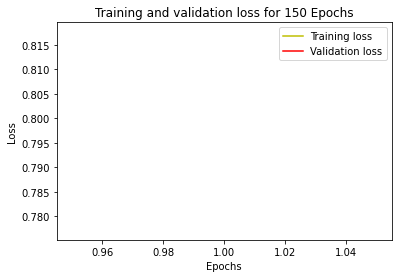

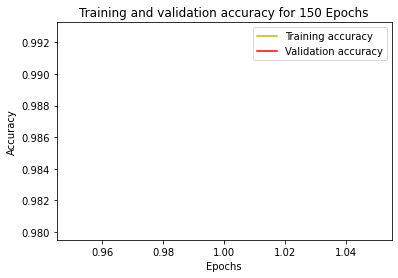

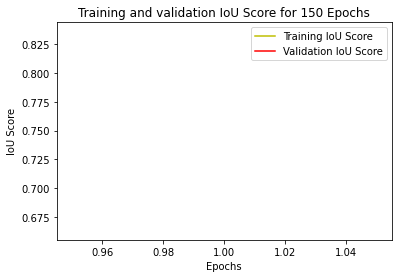

In [ ]:
my_model = load_model(TEST_SAVE + 'saved models/brats_3d_100_updated.hdf5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})


history2=my_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=1,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )


# my_model.save(TEST_SAVE + 'saved models/brats_3d_200.hdf5')

loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss for 100 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy for 100 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

iou = history2.history['iou_score']
val_iou = history2.history['val_iou_score']

plt.plot(epochs, iou, 'y', label='Training IoU Score')
plt.plot(epochs, val_iou, 'r', label='Validation IoU Score')
plt.title('Training and validation IoU Score for 100 Epochs')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.legend()
plt.show()

In [ ]:
# my_model = load_model(TEST_SAVE + 'saved models/brats_3d_150.hdf5',
#                       custom_objects={'dice_loss_plus_1focal_loss': total_loss,
#                                       'iou_score':sm.metrics.IOUScore(threshold=0.5)},
#                       compile=True)


# history2=my_model.fit(train_img_datagen,
#           steps_per_epoch=steps_per_epoch,
#           epochs=50,
#           verbose=1,
#           validation_data=val_img_datagen,
#           validation_steps=val_steps_per_epoch,
#           )


# my_model.save(TEST_SAVE + 'saved models/brats_3d_200.hdf5')

# loss = history2.history['loss']
# val_loss = history2.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss for 200 Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# acc = history2.history['accuracy']
# val_acc = history2.history['val_accuracy']

# plt.plot(epochs, acc, 'y', label='Training accuracy')
# plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
# plt.title('Training and validation accuracy for 200 Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# iou = history2.history['iou_score']
# val_iou = history2.history['val_iou_score']

# plt.plot(epochs, iou, 'y', label='Training IoU Score')
# plt.plot(epochs, val_iou, 'r', label='Validation IoU Score')
# plt.title('Training and validation IoU Score for 200 Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('IoU Score')
# plt.legend()
# plt.show()


In [ ]:
my_model = load_model(TEST_SAVE + 'saved models/brats_3d_100_updated.hdf5',
                      compile=False)

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.69678193


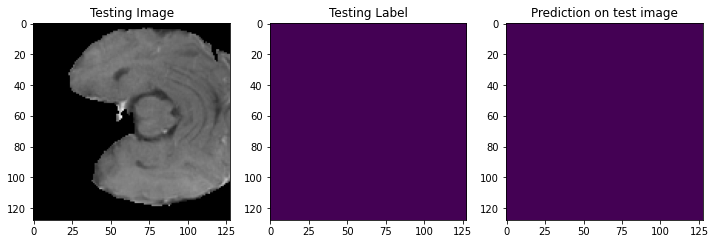

In [ ]:
img_num = 359

test_img = np.load(TEST_SAVE + "input_data_128/val/images/image_"+str(img_num)+".npy")

test_mask = np.load(TEST_SAVE + "input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))


#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()